# TigerGraph Graph Data Science Library 101 - Graph Embedding 

This notebook shows the examples of using graph embedding algorithms in TigerGraph Graph Science Library. More detailed explanations of these algorithms can be four in the official documentation 
(https://docs.tigergraph.com/graph-ml/current/node-embeddings/).  

## Step 1: Load Cora graph data

In [1]:
import json
config_file = open ('../config.json', "r")
config = json.load(config_file)
config_file.close()

In [2]:
from pyTigerGraph.datasets import Datasets

dataset = Datasets("Cora")

Downloading:   0%|          | 0/166537 [00:00<?, ?it/s]

In [3]:
from pyTigerGraph import TigerGraphConnection
import json

conn = TigerGraphConnection(
    host=config["host"],
    username=config["username"],
    password=config["password"],
)

In [4]:
conn.ingestDataset(dataset, getToken=config["getToken"])

---- Checking database ----
---- Creating graph ----
The graph Cora is created.
---- Creating schema ----
Using graph 'Cora'
Successfully created schema change jobs: [cora_schema].
Kick off schema change job cora_schema
Doing schema change on graph 'Cora' (current version: 0)
Trying to add local vertex 'Paper' to the graph 'Cora'.
Trying to add local edge 'Cite' to the graph 'Cora'.

Graph Cora updated to new version 1
The job cora_schema completes in 2.581 seconds!
---- Creating loading job ----
Using graph 'Cora'
Successfully created loading jobs: [load_cora_data].
---- Ingesting data ----
Ingested 2708 objects into VERTEX Paper
Ingested 10556 objects into EDGE Cite
---- Cleaning ----
---- Finished ingestion ----


In [5]:
from pyTigerGraph.visualization import drawSchema

drawSchema(conn.getSchema(force=True))

CytoscapeWidget(cytoscape_layout={'name': 'circle', 'animate': True, 'padding': 1}, cytoscape_style=[{'selecto…

## Step 2: Running Louvain Community Detection
We are going to use the pyTigerGraph featurizer to run Louvain community detection on the citation network.

In [20]:
feat = conn.gds.featurizer()

params = {
    "v_type_set": "Paper",
    "e_type_set": "Cite",
    "weight_attribute": "",
    "maximum_iteration": 10,
    "result_attribute": "community_id",
    "file_path": "",
    "print_stats": True
}

In [21]:
import csv
import os
import time
import psutil
!pip install memory_profiler
%load_ext memory_profiler

algo_performance_out = '/home/tigergraph/GraphML/output/algorithm_' + config["job_id"] + '.csv'

start_time = time.time()

algo_memory = %memit -r 1 -o feat.runAlgorithm("tg_louvain", params = params)

algo_memory = str(algo_memory)

start = algo_memory.find(": ") + 1
end = algo_memory.find("M")

algo_memory = algo_memory[start:end].strip()

execution_time = time.time() - start_time

cpu_usage = psutil.cpu_percent(4)

print('The CPU usage is: ', cpu_usage)

# print('RAM memory % used:', psutil.virtual_memory()[2])

host_memory = psutil.virtual_memory()[3]/1000000000

print('RAM Used (GB):', host_memory)

print ('tg_louvain executed successfully')

print ('execution time: ' + str(execution_time) + ' seconds\n')

algo_id = "embedding_tg_louvain_" + config["job_id"]

nb_id = "algos_embedding.ipynb_" + config["job_id"]

data = [algo_id, "false" ,cpu_usage, algo_memory, execution_time, host_memory, "3.8", "no errors", nb_id]

with open(algo_performance_out, mode='a+', encoding='utf-8') as f:
    writer = csv.writer(f) 
    writer.writerow(data)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 383.54 MiB, increment: 0.08 MiB
The CPU usage is:  28.0
RAM Used (GB): 10.966151168
tg_louvain executed successfully
execution time: 0.7343027591705322 seconds



## Step 3: Leveraging pyTigerGraph’s featurizer to run embedding algorithms

pyTIgerGraph provides a full suit of data science capabilities, and in this tutorial, we will showcase how to use featurizer to run a few popular algorithms as an example.

In [8]:
feat.listAlgorithms("Embeddings")

Available algorithms for Embeddings:
  FastRP:
    01. name: tg_fastRP
Call runAlgorithm() with the algorithm name to execute it


### Install and run fastRP algorithm 

Fast Random Projection (FastRP) is a scalable and performant node-embedding algorithm. It generates node embeddings (vectors) of low dimensionality through random projections from the graph’s adjacency matrix (a high-dimensional matrix) to a low-dimensional matrix, significantly reducing the computing power required to process the data. (https://docs.tigergraph.com/graph-ml/current/node-embeddings/fast-random-projection)

In [9]:
params={"v_type": ["Paper"],
        "e_type": ["Cite"],
        "output_v_type": ["Paper"],
        "iteration_weights": "1,2,4",
        "beta": -0.1,
        "embedding_dimension": 128,
        "embedding_dim_map": [],
        "default_length": 128,
        "sampling_constant": 3,
        "random_seed": 42,
        "component_attribute": "",
        "result_attribute": "embedding",
        "choose_k": 0}

In [10]:
start_time = time.time()

algo_memory = %memit -r 1 -o feat.runAlgorithm("tg_fastRP", params=params)

algo_memory = str(algo_memory)

start = algo_memory.find(": ") + 1
end = algo_memory.find("M")

algo_memory = algo_memory[start:end].strip()

execution_time = time.time() - start_time

cpu_usage = psutil.cpu_percent(4)

print('The CPU usage is: ', cpu_usage)

# print('RAM memory % used:', psutil.virtual_memory()[2])

host_memory = psutil.virtual_memory()[3]/1000000000

print('RAM Used (GB):', host_memory)

print ('tg_fastRP executed successfully')

print ('execution time: ' + str(execution_time) + ' seconds\n')

algo_id = "tg_fastRP_" + config["job_id"]

nb_id = "algos_embedding.ipynb_" + config["job_id"]

data = [algo_id, "false" ,cpu_usage, algo_memory, execution_time, host_memory, "3.8", "no errors", nb_id]

with open(algo_performance_out, mode='a+', encoding='utf-8') as f:
    writer = csv.writer(f) 
    writer.writerow(data)

Altering graph schema to save results...
The job add_VERTEX_attr_zNbluz completes in 25.035 seconds!
Installing and optimizing the queries, it might take a minute...
Queries installed successfully
peak memory: 125.03 MiB, increment: 0.70 MiB
The CPU usage is:  37.8
RAM Used (GB): 10.806849536
tg_fastRP executed successfully
execution time: 72.01924395561218 seconds



In [11]:
df = conn.getVertexDataFrame("Paper")

In [12]:
df.head()

,v_id,id,x,y,train_mask,val_mask,test_mask,community_id,embedding
0,2706,2706,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,False,False,True,434110464,"[0.28447, 0.31007, -0.04838, 0.0147, -0.03486,..."
1,2680,2680,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,False,False,True,434110465,"[0.08188, 0.33518, -0.34322, -0.24893, 0.13559..."
2,2482,2482,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,False,False,True,434110466,"[-0.13238, -0.19143, -0.19143, 0.19143, -0.378..."
3,2383,2383,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,False,False,True,434110467,"[-0.00764, 0.24286, -0.056, 0.1696, -0.10296, ..."
4,2374,2374,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,False,False,True,356515917,"[0.22167, -0.13319, 0.29308, -0.18034, -0.1556..."


In [13]:
import pandas as pd

pd.DataFrame(df['community_id'].value_counts()).value_counts().sort_index()

community_id
1               1925
2                314
3                 29
4                  7
5                  3
12                 1
13                 1
dtype: int64

### Compute intra- and inter-communities similarities for FastRP embeddings using Louvain Communities

In [14]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

cnt = 5
comms_list = ['community_id']

for comm in comms_list:
    print(f"***Community Detection ID: {comm}***\n")
    
    comm_embs = None
    print("Intra-community similarities:\n")

    for i, c_id in enumerate(df[comm].value_counts().head(cnt).index):
        community = df[df[comm] == c_id]
        comm_embs = np.stack(community["embedding"].values)
        similarities = cosine_similarity(comm_embs)
        print(f"Community: {i}")
        print(f"Number of members in community: {len(comm_embs)}")
        print(f"Mean intra-community similarity: {similarities.mean()}")
        print(f"Std. Dev. of intra-community similarity: {np.std(similarities)}")
        print()

    print("Inter-community similarities:\n")

    for i, c_id in enumerate(df[comm].value_counts().head(cnt).index):
        community = df[df[comm] == c_id]
        comm_embs_comp = comm_embs
        comm_embs = np.stack(community["embedding"].values)

        if i >= 1:
            similarities = cosine_similarity(comm_embs_comp, comm_embs)
            print(f"Communities: {i-1}-{i}")
            print(f"Mean inter-community similarity: {similarities.mean()}")
            print(f"Std. Dev. of intra-community similarity: {np.std(similarities)}")
            print()

***Community Detection ID: community_id***

Intra-community similarities:

Community: 0
Number of members in community: 13
Mean intra-community similarity: 0.9965714170704697
Std. Dev. of intra-community similarity: 0.00842738895698873

Community: 1
Number of members in community: 12
Mean intra-community similarity: 0.9978979744962666
Std. Dev. of intra-community similarity: 0.004950015466634065

Community: 2
Number of members in community: 5
Mean intra-community similarity: 0.9954623831664924
Std. Dev. of intra-community similarity: 0.006614656368356073

Community: 3
Number of members in community: 5
Mean intra-community similarity: 0.9983262887331829
Std. Dev. of intra-community similarity: 0.0024398324706672173

Community: 4
Number of members in community: 5
Mean intra-community similarity: 0.9885478124522032
Std. Dev. of intra-community similarity: 0.016694288670487428

Inter-community similarities:

Communities: 0-1
Mean inter-community similarity: 0.016267563777136545
Std. Dev. o

In [15]:
# Grab embeddings for Louvain Communities

c_id0 = df["community_id"].value_counts().head(25).index[0]
c_id1 = df["community_id"].value_counts().head(25).index[1]
c_id2 = df["community_id"].value_counts().head(25).index[2]
c_id3 = df["community_id"].value_counts().head(25).index[3]
c_id4 = df["community_id"].value_counts().head(25).index[4]

community0 = df[df["community_id"] == c_id0]
comm_embs0 = np.stack(community0["embedding"].values)

community1 = df[df["community_id"] == c_id1]
comm_embs1 = np.stack(community1["embedding"].values)

community2 = df[df["community_id"] == c_id2]
comm_embs2 = np.stack(community2["embedding"].values)

community3 = df[df["community_id"] == c_id3]
comm_embs3 = np.stack(community3["embedding"].values)

community4 = df[df["community_id"] == c_id4]
comm_embs4 = np.stack(community4["embedding"].values)

X = np.vstack((comm_embs0, comm_embs1, comm_embs2, comm_embs3, comm_embs4))

y0 = np.ones((comm_embs0.shape[0])) * 0
y1 = np.ones((comm_embs1.shape[0])) * 1
y2 = np.ones((comm_embs2.shape[0])) * 2
y3 = np.ones((comm_embs3.shape[0])) * 3
y4 = np.ones((comm_embs4.shape[0])) * 4
y = np.hstack((y0,y1,y2,y3,y4))

### Plot embeddings in 2D space

In [16]:
!pip install umap
!pip install umap-learn
!pip install seaborn

In [17]:
import umap.umap_ as umap

embd_x = umap.UMAP().fit_transform(X)

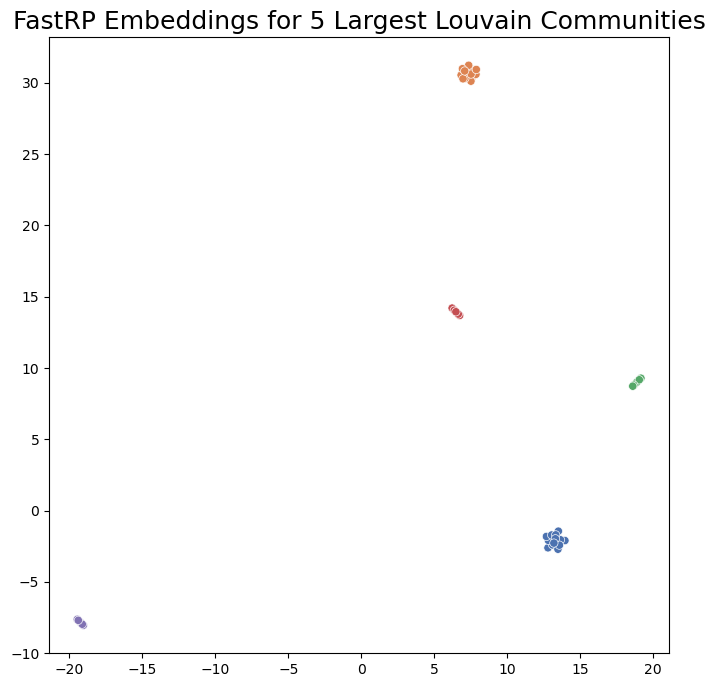

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
sns.set(font_scale=1)

palette = {}
for n, i in enumerate(set([0, 1, 2, 3, 4])):
    palette[i] = f'C{n}'
    
sns.scatterplot(ax=axs, x=embd_x.T[0], y=embd_x.T[1], hue=y, palette=palette)
axs.get_legend().remove()
plt.title("FastRP Embeddings for 5 Largest Louvain Communities", fontsize=18)

plt.show()